## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading the model and data

In [2]:
#get cwd    
import os
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

#change to  /Users/ulisesgordillo/Downloads/capstone/data
os.chdir('/Users/ulisesgordillo/Downloads/capstone/model_output/second_model')
cwd = os.getcwd()
print(f"Current working directory: {cwd}")







Current working directory: /Users/ulisesgordillo/Downloads/capstone/EDA/stratification
Current working directory: /Users/ulisesgordillo/Downloads/capstone/model_output/second_model


In [3]:
model_lgb = None
X_test = None
final_df = None

# --- Load the Model ---
try:
    model_lgb = joblib.load('lightgbm_model.joblib')
except Exception as e:
    print(f"ERROR loading model_lgb: {e}")

# --- Load X_test ---
try:
    X_test = pd.read_parquet('X_test_model_features.parquet')
except Exception: # Broad exception to catch FileNotFoundError or Parquet read errors
    try:
        X_test = pd.read_csv('X_test_model_features.csv')
    except Exception as e_csv:
        print(f"ERROR loading X_test (tried Parquet and CSV): {e_csv}")

# --- Load final_df ---
try:
    final_df = pd.read_parquet('final_df_for_analysis.parquet')
except Exception: # Broad exception
    try:
        final_df = pd.read_csv('final_df_for_analysis.csv')
        if final_df is not None and 'DateOfReport' in final_df.columns: # Check if df loaded
            final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'], errors='coerce')
    except Exception as e_csv:
        print(f"ERROR loading final_df (tried Parquet and CSV): {e_csv}")

# --- Check if all loaded successfully before proceeding ---
if model_lgb is not None and X_test is not None and final_df is not None:
    # Proceed with your stratification logic using model_lgb, X_test, final_df
    # print("All components loaded successfully.") # Optional: uncomment for a success message
    pass
else:
    print("One or more essential components failed to load. Cannot proceed with analysis.")

In [4]:
# --- Step 1: Configuration for Stratification ---
probability_class_idx_for_strata = 0
strata_config = {
    'labels': ['Lowest_Risk', 'Low_Risk', 'Medium_Risk', 'High_Risk', 'Highest_Risk'],
    'quantiles': [0, 0.40, 0.65, 0.85, 0.97, 1.0]
    }    # Most packages in safe categories
# Dynamically create the names for the new columns
proba_col_name = f'probability_class{probability_class_idx_for_strata}'
stratum_col_name = f'stratum_class{probability_class_idx_for_strata}' # This is THE key variable

# --- Step 2: Function to Assign Strata ---
def assign_strata_from_probabilities(
    trained_model, features_for_prediction, df_to_add_strata_to,
    prob_class_idx, strata_definition, new_proba_col_name, new_stratum_col_name
):
    all_class_probs = trained_model.predict_proba(features_for_prediction)
    selected_probs = all_class_probs[:, prob_class_idx]
    output_df = df_to_add_strata_to.copy()
    output_df[new_proba_col_name] = selected_probs
    try:
        output_df[new_stratum_col_name] = pd.qcut(
            output_df[new_proba_col_name], q=strata_definition['quantiles'],
            labels=strata_definition['labels'], duplicates='drop'
        )
    except Exception:
        output_df[new_stratum_col_name] = np.nan
    return output_df

# --- Step 3: Create the Stratified DataFrame ---
stratified_df = None # Initialize
if ('model_lgb' in locals() and
    'X_test' in locals() and isinstance(X_test, pd.DataFrame) and
    'final_df' in locals() and isinstance(final_df, pd.DataFrame)):

    # Ensure DateOfReport is datetime in final_df if it's going to be used for filtering
    if 'DateOfReport' in final_df.columns and final_df['DateOfReport'].dtype != '<M8[ns]':
         final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'])
    if 'SupplierName' not in final_df.columns: # Basic check
        print("Warning: 'SupplierName' not found in final_df. Supplier filtering will not work.")


    stratified_df = assign_strata_from_probabilities(
        model_lgb, X_test, final_df, probability_class_idx_for_strata,
        strata_config, proba_col_name, stratum_col_name
    )
else:
    print("Initial setup skipped: Required variables (model_lgb, X_test, final_df) not found or not of correct type.")

## Stratification

In [5]:
def print_stratum_distribution(df, column_name, config_labels, description="Data"):
    if df is None or df.empty:
        print(f"No data for: {description}")
        return
    if column_name not in df.columns or df[column_name].isnull().all():
        print(f"Stratum column '{column_name}' missing or all NaNs for: {description}")
        return

    print(f"\n--- Stratum Distribution for: {description} (Total: {df.shape[0]}) ---")
    counts = df[column_name].value_counts().sort_index()
    percentages = df[column_name].value_counts(normalize=True).sort_index() * 100
    for label in config_labels:
        c = counts.get(label, 0)
        p = percentages.get(label, 0.0)
        print(f"  {label}: {c} ({p:.2f}%)")

#Manual definition of the stratification column and its configuration
# Example: (Replace with your actual values)
filter_supplier_name = 'SupplierA'
filter_start_date = pd.to_datetime('2023-10-01')
filter_end_date = pd.to_datetime('2023-10-31')
# --- END OF MANUAL DEFINITION ---

if 'stratified_df' in locals() and stratified_df is not None:
    # 1. Filter by Supplier
    if filter_supplier_name and 'SupplierName' in stratified_df.columns:
        supplier_filtered_df = stratified_df[stratified_df['SupplierName'] == filter_supplier_name]
        print_stratum_distribution(supplier_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Supplier: {filter_supplier_name}")

    # 2. Filter by Date Range
    if filter_start_date and filter_end_date and 'DateOfReport' in stratified_df.columns:
        # Ensure DateOfReport is datetime if not already done
        if stratified_df['DateOfReport'].dtype != '<M8[ns]':
            stratified_df['DateOfReport'] = pd.to_datetime(stratified_df['DateOfReport'])

        date_filtered_df = stratified_df[
            (stratified_df['DateOfReport'] >= filter_start_date) &
            (stratified_df['DateOfReport'] <= filter_end_date)
        ]
        print_stratum_distribution(date_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Date: {filter_start_date.strftime('%Y-%m-%d')} to {filter_end_date.strftime('%Y-%m-%d')}")

    # 3. Filter by BOTH Supplier AND Date Range
    if filter_supplier_name and filter_start_date and filter_end_date and \
       'SupplierName' in stratified_df.columns and 'DateOfReport' in stratified_df.columns:
        # Ensure DateOfReport is datetime
        if stratified_df['DateOfReport'].dtype != '<M8[ns]':
            stratified_df['DateOfReport'] = pd.to_datetime(stratified_df['DateOfReport'])

        both_filtered_df = stratified_df[
            (stratified_df['SupplierName'] == filter_supplier_name) &
            (stratified_df['DateOfReport'] >= filter_start_date) &
            (stratified_df['DateOfReport'] <= filter_end_date)
        ]
        print_stratum_distribution(both_filtered_df, stratum_col_name, strata_config['labels'],
                                   description=f"Supplier: {filter_supplier_name} AND Date: {filter_start_date.strftime('%Y-%m-%d')} to {filter_end_date.strftime('%Y-%m-%d')}")
else:
    print("`stratified_df` not found or is None. Cannot perform filtering.")


--- Stratum Distribution for: Supplier: SupplierA (Total: 40410) ---
  Lowest_Risk: 33441 (82.75%)
  Low_Risk: 6500 (16.09%)
  Medium_Risk: 426 (1.05%)
  High_Risk: 40 (0.10%)
  Highest_Risk: 3 (0.01%)

--- Stratum Distribution for: Date: 2023-10-01 to 2023-10-31 (Total: 7840) ---
  Lowest_Risk: 3041 (38.79%)
  Low_Risk: 1755 (22.39%)
  Medium_Risk: 1817 (23.18%)
  High_Risk: 965 (12.31%)
  Highest_Risk: 262 (3.34%)

--- Stratum Distribution for: Supplier: SupplierA AND Date: 2023-10-01 to 2023-10-31 (Total: 2159) ---
  Lowest_Risk: 1748 (80.96%)
  Low_Risk: 385 (17.83%)
  Medium_Risk: 26 (1.20%)
  High_Risk: 0 (0.00%)
  Highest_Risk: 0 (0.00%)


## EDA

### Historic


--- Stratum Distribution for: Overall Dataset (Total: 142177) ---
  Lowest_Risk: 56871 (40.00%)
  Low_Risk: 35544 (25.00%)
  Medium_Risk: 28435 (20.00%)
  High_Risk: 17061 (12.00%)
  Highest_Risk: 4266 (3.00%)


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


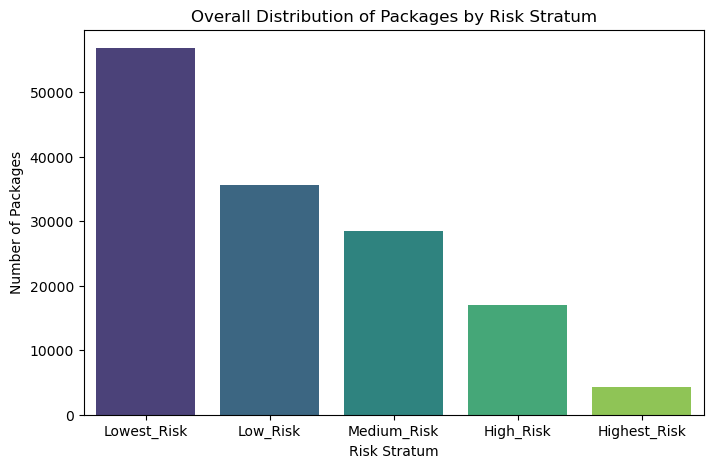

In [22]:
if 'stratified_df' in locals() and stratified_df is not None and stratum_col_name in stratified_df.columns:
    print_stratum_distribution(stratified_df, stratum_col_name, strata_config['labels'],
                               description="Overall Dataset")

    plt.figure(figsize=(8, 5))
    sns.countplot(data=stratified_df, x=stratum_col_name, order=strata_config['labels'], palette="viridis")
    plt.title('Overall Distribution of Packages by Risk Stratum')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Number of Packages')
    plt.show()
else:
    print("Skipping Overall Analysis: stratified_df not available or stratum column missing.")


--- Both Actual and Predicted Quality per Risk Stratum ---
                Total_Packages  Actual_Good_Rate  Avg_PredictedQualityProba
stratum_class0                                                             
Lowest_Risk              56871          0.908178                   0.740599
Low_Risk                 35544          0.804158                   0.519268
Medium_Risk              28435          0.714823                   0.395443
High_Risk                17061          0.649083                   0.310882
Highest_Risk              4266          0.572902                   0.225835


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/2781709039.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_actual_quality_summary = stratified_df.groupby(stratum_col_name)['ActualQuality'].agg(
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/2781709039.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_predicted_quality_per_stratum = stratified_df.groupby(stratum_col_name)['PredictedQualityProba'].mean().reindex(strata_config['labels'])


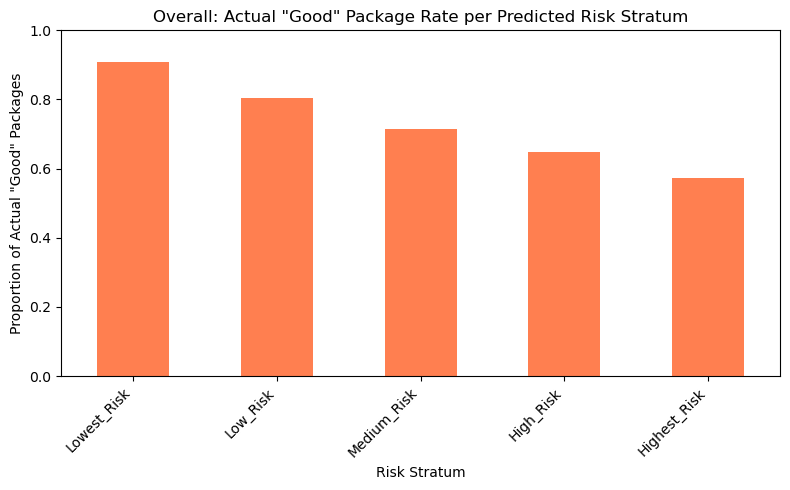

In [7]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'ActualQuality' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    overall_actual_quality_summary = stratified_df.groupby(stratum_col_name)['ActualQuality'].agg(
        Total_Packages='count',
        Actual_Good_Rate='mean'
    ).reindex(strata_config['labels'])

    avg_predicted_quality_per_stratum = stratified_df.groupby(stratum_col_name)['PredictedQualityProba'].mean().reindex(strata_config['labels'])

    print("\n--- Both Actual and Predicted Quality per Risk Stratum ---")
    combined_df = overall_actual_quality_summary.copy()
    combined_df['Avg_PredictedQualityProba'] = avg_predicted_quality_per_stratum
    print(combined_df)

    if not overall_actual_quality_summary['Actual_Good_Rate'].isnull().all():
        plt.figure(figsize=(8, 5))
        overall_actual_quality_summary['Actual_Good_Rate'].plot(kind='bar', color='coral')
        plt.title('Overall: Actual "Good" Package Rate per Predicted Risk Stratum')
        plt.xlabel('Risk Stratum')
        plt.ylabel('Proportion of Actual "Good" Packages')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.tight_layout()

        
else:
    print("Skipping Overall Actual Quality Analysis: relevant columns missing.")



/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/4229286757.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  supplier_composition_in_strata = stratified_df.groupby([stratum_col_name, 'SupplierName']).size().reset_index(name='Package_Count')
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/4229286757.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  stratum_supplier_pivot = supplier_composition_in_strata.pivot_table(


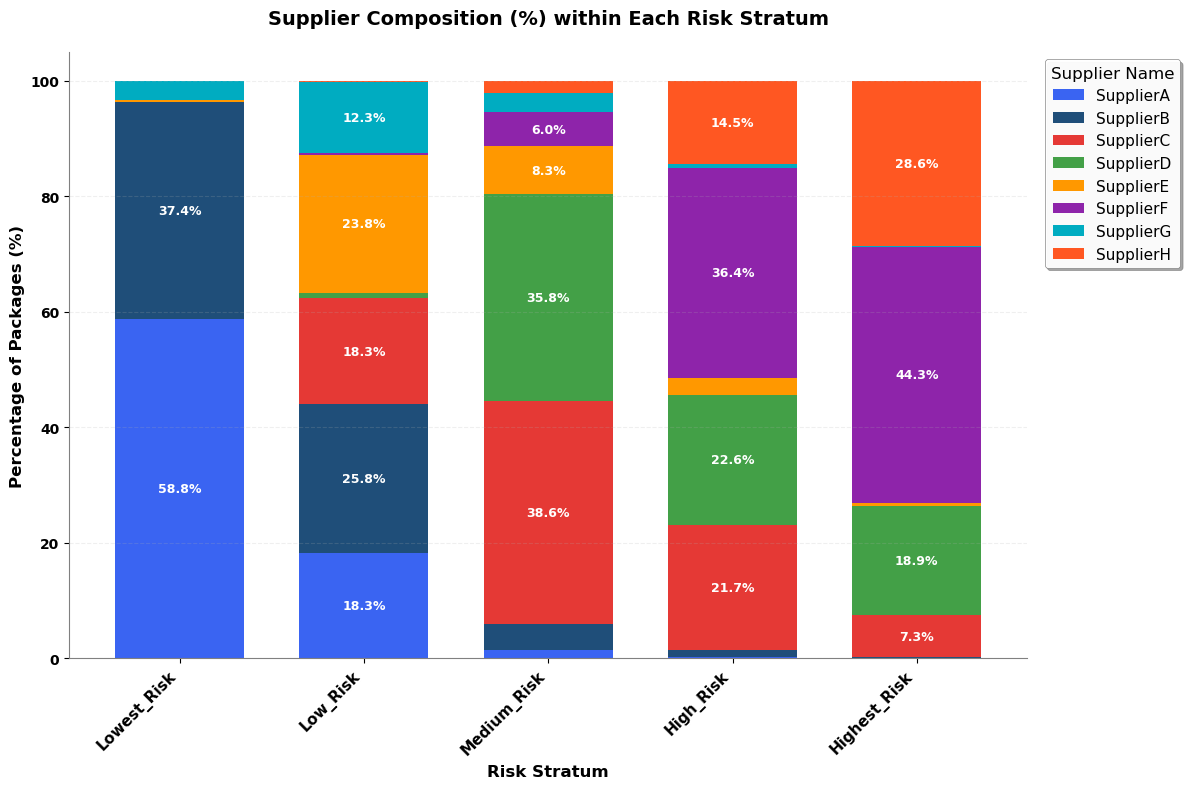

In [8]:
# Group by stratum, then by supplier, and count packages
supplier_composition_in_strata = stratified_df.groupby([stratum_col_name, 'SupplierName']).size().reset_index(name='Package_Count')

# For a cleaner plot, let's pivot and then normalize to get percentages
stratum_supplier_pivot = supplier_composition_in_strata.pivot_table(
    index=stratum_col_name,
    columns='SupplierName',
    values='Package_Count',
    fill_value=0
)

# Normalize across each row (stratum) to get percentage contribution of each supplier to that stratum
stratum_supplier_percentage = stratum_supplier_pivot.apply(lambda x: (x / x.sum()) * 100, axis=1)
stratum_supplier_percentage = stratum_supplier_percentage.reindex(strata_config['labels'])  # Ensure order

# Plotting with improved sizing and professional colors
if not stratum_supplier_percentage.empty:
    num_suppliers = stratum_supplier_percentage.shape[1]
    num_strata = stratum_supplier_percentage.shape[0]
    
    # Calculate appropriate figure size based on content
    fig_width = max(12, num_strata * 2)  # Wider for better spacing
    fig_height = 8  # Fixed height for better proportions
    
    # Create the plot with professional colors matching your presentation
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Use your theme blue and navy with complementary high-contrast colors
    colors = ['#3a64f2', '#1f4e79', '#e53935', '#43a047', '#ff9800', 
              '#8e24aa', '#00acc1', '#ff5722', '#795548', '#607d8b',
              '#4caf50', '#2196f3', '#f44336', '#ffeb3b', '#9c27b0']
    
    # If more suppliers than colors, use a colormap
    if num_suppliers > len(colors):
        import matplotlib.cm as cm
        colors = cm.Set3(range(num_suppliers))
    
    stratum_supplier_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(fig_width, fig_height),
        color=colors[:num_suppliers],
        ax=ax,
        width=0.7  # Make bars slightly thinner for better appearance
    )
    
    # Customize the plot
    plt.title('Supplier Composition (%) within Each Risk Stratum', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Risk Stratum', fontsize=12, fontweight='bold')
    plt.ylabel('Percentage of Packages (%)', fontsize=12, fontweight='bold')
    
    # Improve x-axis labels with bold formatting
    plt.xticks(rotation=0 if num_strata <= 4 else 45, ha='center' if num_strata <= 4 else 'right', 
               fontweight='bold', fontsize=11)
    
    # Make y-axis tick labels bold
    plt.yticks(fontweight='bold', fontsize=10)
    
    # Improve legend positioning and formatting
    legend = plt.legend(
        title='Supplier Name', 
        bbox_to_anchor=(1.01, 1), 
        loc='upper left',
        fontsize=11,
        title_fontsize=12,
        frameon=True,
        fancybox=True,
        shadow=True,
        ncol=1
    )
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(0.5)
    
    # Add subtle styling improvements  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    # Remove gray color override to keep bold black text
    
    # Add grid for better readability
    plt.grid(True, alpha=0.2, axis='y', linestyle='--')
    
    # Ensure everything fits properly
    plt.tight_layout()
    
    # Add percentage labels only for segments larger than 5% to avoid clutter
    if num_strata <= 8:
        for i, container in enumerate(ax.containers):
            labels = []
            for j, bar in enumerate(container):
                height = bar.get_height()
                if height > 5:  # Only show labels for segments > 5%
                    labels.append(f'{height:.1f}%')
                else:
                    labels.append('')
            ax.bar_label(container, labels=labels, label_type='center', 
                        fontsize=9, fontweight='bold', color='white')
    
    plt.show()
else:
    print("No data available to plot for supplier composition.")

#### Suppliers

In [9]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'SupplierName' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("OVERALL SUPPLIER COMPOSITION WITHIN EACH RISK STRATUM " )

    # --- Option 1: Table showing top N suppliers per stratum ---
    print("Top Suppliers Contributing to Each Risk Stratum (by Package Count)")
    for stratum_label in strata_config['labels']:
        print(f"\n  Stratum: {stratum_label}")
        top_suppliers_in_stratum = supplier_composition_in_strata[
            supplier_composition_in_strata[stratum_col_name] == stratum_label
        ].sort_values(by='Package_Count', ascending=False).head(5) # Show top 5 for brevity
        if not top_suppliers_in_stratum.empty:
            # Calculate percentage within this stratum for these top suppliers
            total_packages_in_stratum = stratified_df[stratified_df[stratum_col_name] == stratum_label].shape[0]
            top_suppliers_in_stratum['Percentage_of_Stratum'] = \
                (top_suppliers_in_stratum['Package_Count'] / total_packages_in_stratum) * 100
            print(top_suppliers_in_stratum[['SupplierName', 'Package_Count', 'Percentage_of_Stratum']].to_string(index=False))
        else:
            print("    No suppliers found in this stratum (or stratum is empty).")


OVERALL SUPPLIER COMPOSITION WITHIN EACH RISK STRATUM 
Top Suppliers Contributing to Each Risk Stratum (by Package Count)

  Stratum: Lowest_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierA          33441              58.801498
   SupplierB          21282              37.421533
   SupplierG           1934               3.400679
   SupplierE            140               0.246171
   SupplierC             63               0.110777

  Stratum: Low_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierB           9153              25.751182
   SupplierE           8468              23.823993
   SupplierA           6500              18.287193
   SupplierC           6499              18.284380
   SupplierG           4388              12.345262

  Stratum: Medium_Risk
SupplierName  Package_Count  Percentage_of_Stratum
   SupplierC          10965              38.561632
   SupplierD          10175              35.783366
   SupplierE           2347               8.

In [10]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'SupplierName' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: Supplier Risk Profile Summary Table ---")
    supplier_summary_list = []
    unique_suppliers = sorted(stratified_df['SupplierName'].unique())

    for supplier_name_iter in unique_suppliers: # Renamed to avoid conflict with filter_supplier_name
        supplier_df_iter = stratified_df[stratified_df['SupplierName'] == supplier_name_iter]
        if supplier_df_iter.empty:
            continue

        summary = {'SupplierName': supplier_name_iter, 'TotalPackages': len(supplier_df_iter)}
        
        # Percentage of THIS SUPPLIER's packages in each global stratum
        stratum_dist_for_supplier = supplier_df_iter[stratum_col_name].value_counts(normalize=True).reindex(strata_config['labels'], fill_value=0) * 100
        for label in strata_config['labels']:
            summary[f'%_in_{label}'] = stratum_dist_for_supplier.get(label, 0.0)

        if 'ActualQuality' in supplier_df_iter.columns:
            summary['Overall_Actual_Good_Rate'] = supplier_df_iter['ActualQuality'].mean() * 100 # As percentage
            # Actual good rate in specific strata for this supplier
            highest_risk_label = strata_config['labels'][0] # Assumes first label is highest risk
            lowest_risk_label = strata_config['labels'][-1] # Assumes last label is lowest risk

            for risk_label_iter in [highest_risk_label, lowest_risk_label]: # Renamed for clarity
                 stratum_subset = supplier_df_iter[supplier_df_iter[stratum_col_name] == risk_label_iter]
                 if not stratum_subset.empty:
                     summary[f'Actual_Good_Rate_in_{risk_label_iter}'] = stratum_subset['ActualQuality'].mean() * 100
                 else:
                     summary[f'Actual_Good_Rate_in_{risk_label_iter}'] = np.nan
        supplier_summary_list.append(summary)

    supplier_overview_table = pd.DataFrame(supplier_summary_list)
    
    # Example: Sort by percentage in the 'Highest_Risk' stratum
    highest_risk_col_name_for_sort = f"%_in_{strata_config['labels'][0]}" # Assumes first label is highest risk
    if highest_risk_col_name_for_sort in supplier_overview_table.columns:
        sorted_supplier_overview = supplier_overview_table.sort_values(by=highest_risk_col_name_for_sort, ascending=False)
    else:
        sorted_supplier_overview = supplier_overview_table # Fallback

    print(f"Displaying overview for {len(sorted_supplier_overview)} suppliers (sorted by % in '{strata_config['labels'][0]}'):")
    # Format percentages for display
    percent_cols = [col for col in sorted_supplier_overview.columns if '%' in col or 'Rate' in col]
    styled_table = sorted_supplier_overview.style.format({col: '{:.2f}%' for col in percent_cols}, na_rep='-')
    
    # To print styled table in notebook (might be long, consider .head()):
    # display(styled_table) # Use display for Styler objects
    print(sorted_supplier_overview.to_string(index=False, float_format="%.2f")) # Simpler print, less pretty for %

else:
    print("Skipping Supplier Overview Table: relevant columns missing in stratified_df.")



--- Overall Dataset: Supplier Risk Profile Summary Table ---
Displaying overview for 8 suppliers (sorted by % in 'Lowest_Risk'):
SupplierName  TotalPackages  %_in_Lowest_Risk  %_in_Low_Risk  %_in_Medium_Risk  %_in_High_Risk  %_in_Highest_Risk  Overall_Actual_Good_Rate  Actual_Good_Rate_in_Lowest_Risk  Actual_Good_Rate_in_Highest_Risk
   SupplierA          40410             82.75          16.09              1.05            0.10               0.01                     91.79                            93.41                            100.00
   SupplierB          31923             66.67          28.67              4.03            0.62               0.02                     84.99                            87.42                             60.00
   SupplierG           7356             26.29          59.65             12.52            1.45               0.08                     82.79                            84.80                             83.33
   SupplierE          11477              



--- Overall Dataset: Supplier Risk Profile Distribution (Chart) ---


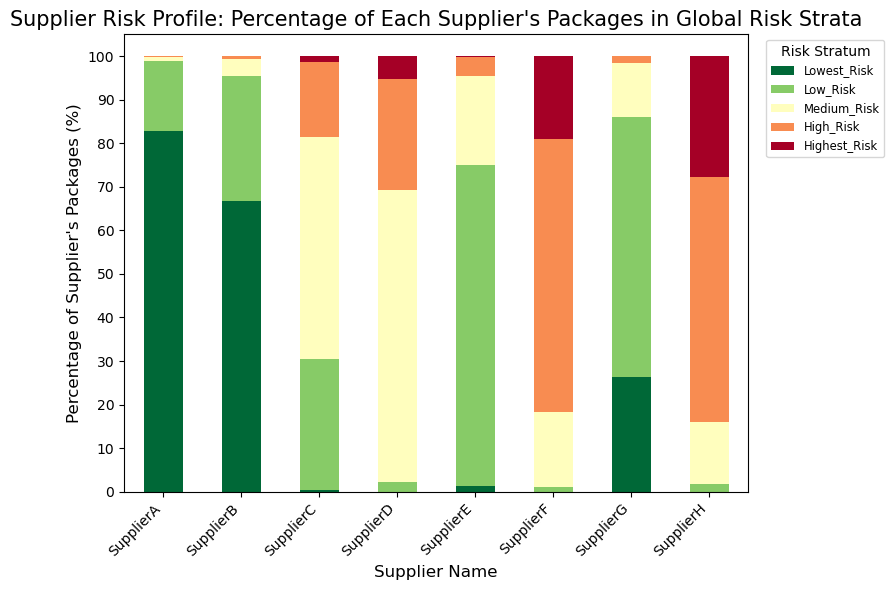

In [11]:
if 'supplier_overview_table' in locals() and not supplier_overview_table.empty:
    print("\n\n--- Overall Dataset: Supplier Risk Profile Distribution (Chart) ---")
    
    # Select only the percentage columns for the strata and SupplierName
    strata_percentage_columns = [f"%_in_{label}" for label in strata_config['labels']]
    
    # Check if all expected percentage columns are in the table
    missing_cols = [col for col in strata_percentage_columns if col not in supplier_overview_table.columns]
    if missing_cols:
        print(f"Warning: Missing percentage columns for plotting: {missing_cols}")
        # Proceed with available columns, or handle error
        strata_percentage_columns = [col for col in strata_percentage_columns if col in supplier_overview_table.columns]

    if not strata_percentage_columns:
        print("No strata percentage columns found to plot.")
    else:
        # Set SupplierName as index for easier plotting
        plot_df = supplier_overview_table.set_index('SupplierName')[strata_percentage_columns].copy()
        
        # Rename columns for a cleaner legend (optional, but good practice)
        # Current names: %_in_Lowest_Risk, etc. We want: Lowest_Risk, etc.
        plot_df.columns = [col.replace('%_in_', '') for col in plot_df.columns]
        
        # Ensure the columns are in the desired stratum order for stacking
        # (strata_config['labels'] should provide this order)
        ordered_strata_labels_for_plot = [label for label in strata_config['labels'] if label in plot_df.columns]
        plot_df = plot_df[ordered_strata_labels_for_plot]

        # Determine number of suppliers for plot height adjustment
        num_suppliers = len(plot_df)
        plot_height = max(6, num_suppliers * 0.35) # Adjust multiplier as needed
        plot_width = max(10, num_suppliers * 0.8) # Adjust width

        plot_df.plot(
            kind='bar',
            stacked=True,
            figsize=(min(plot_width, 20), plot_height), # Cap width
            colormap='RdYlGn_r' # Red-Yellow-Green reversed: Red for Highest_Risk, Green for Lowest_Risk
                               # (Assumes strata_config['labels'] is [Highest, High, Med, Low, Lowest])
                               # If your labels are [Lowest, Low,...Highest], use 'RdYlGn'
        )
        
        plt.title('Supplier Risk Profile: Percentage of Each Supplier\'s Packages in Global Risk Strata', fontsize=15)
        plt.xlabel('Supplier Name', fontsize=12)
        plt.ylabel('Percentage of Supplier\'s Packages (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(np.arange(0, 101, 10)) # Y-ticks from 0 to 100
        plt.legend(title='Risk Stratum', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect for legend
        plt.show()
else:
    print("Skipping Supplier Risk Profile Chart: `supplier_overview_table` not found or is empty.")

#### Garments

In [12]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'GarmentType' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: How Each Garment Type Distributes Across Risk Strata ---")

    # Group by GarmentType, then by stratum, and count packages
    garment_strata_distribution = stratified_df.groupby(['GarmentType', stratum_col_name]) \
                                      .size().reset_index(name='Package_Count')

    # Pivot to have GarmentType as index, strata as columns
    garment_pivot = garment_strata_distribution.pivot_table(
        index='GarmentType',
        columns=stratum_col_name,
        values='Package_Count',
        fill_value=0
    )

    # Ensure all strata labels are columns, even if a garment type has 0 in some
    for label in strata_config['labels']:
        if label not in garment_pivot.columns:
            garment_pivot[label] = 0
    garment_pivot = garment_pivot[strata_config['labels']] # Order columns

    # Normalize across each row (GarmentType) to get percentages
    garment_strata_percentage = garment_pivot.apply(lambda x: (x / x.sum()) * 100, axis=1)
    
    # Add total count for context
    garment_totals = stratified_df['GarmentType'].value_counts()
    garment_strata_percentage['Total_Packages_for_GarmentType'] = garment_totals
    
    # Sort by total packages or by percentage in a key stratum for better viewing
    # Example: sort by percentage in the 'Highest_Risk' stratum
    highest_risk_label = strata_config['labels'][0] # Assuming first label is highest risk
    if highest_risk_label in garment_strata_percentage.columns:
        sorted_garment_strata_percentage = garment_strata_percentage.sort_values(
            by=highest_risk_label, ascending=False
        )
    else:
        sorted_garment_strata_percentage = garment_strata_percentage.sort_values(
            by='Total_Packages_for_GarmentType', ascending=False
        )


    print(sorted_garment_strata_percentage.to_string(float_format="%.2f%%")) # Print the table




--- Overall Dataset: How Each Garment Type Distributes Across Risk Strata ---
stratum_class0  Lowest_Risk  Low_Risk  Medium_Risk  High_Risk  Highest_Risk  Total_Packages_for_GarmentType
GarmentType                                                                                                
Dress                44.36%    21.65%       20.89%     11.30%         1.80%                           11649
Skirt                43.86%    23.35%       19.77%     10.69%         2.33%                           11533
Pants                42.77%    23.78%       20.75%     10.92%         1.78%                           21597
Blouse               42.39%    23.43%       18.97%     11.88%         3.33%                            6547
Shorts               42.22%    25.75%       18.79%     11.29%         1.95%                            7537
Shirt                41.65%    24.09%       20.63%     11.69%         1.93%                           29099
Sweater              41.65%    25.87%       18.88%     1

/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/549039911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  garment_strata_distribution = stratified_df.groupby(['GarmentType', stratum_col_name]) \
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/549039911.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  garment_pivot = garment_strata_distribution.pivot_table(


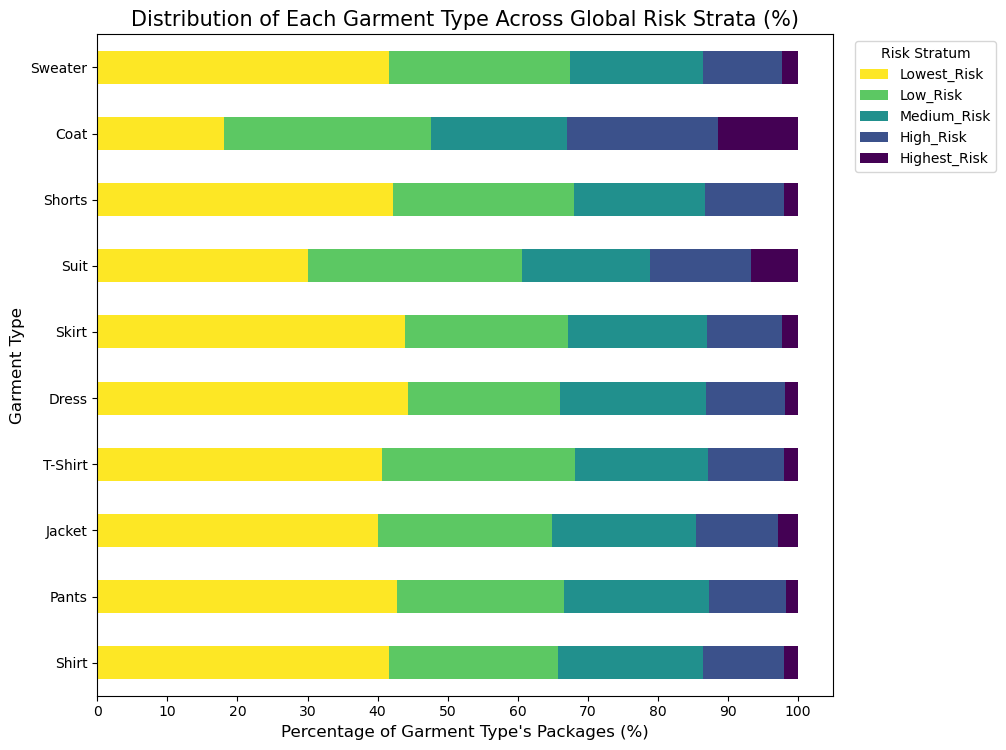

In [13]:
top_n_garments_for_plot = garment_totals.nlargest(10).index
plot_df_garment_dist = sorted_garment_strata_percentage.loc[top_n_garments_for_plot, strata_config['labels']]

if not plot_df_garment_dist.empty:
        plot_df_garment_dist.plot(
            kind='barh', # Horizontal bar chart can be good here
            stacked=True,
            figsize=(12, max(8, len(top_n_garments_for_plot) * 0.6)),
            colormap='viridis_r' # Example colormap
        )
        plt.title('Distribution of Each Garment Type Across Global Risk Strata (%)', fontsize=15)
        plt.xlabel('Percentage of Garment Type\'s Packages (%)', fontsize=12)
        plt.ylabel('Garment Type', fontsize=12)
        plt.xticks(np.arange(0, 101, 10))
        plt.legend(title='Risk Stratum', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0.05, 0.85, 1])
        plt.show()
else:
      print("Skipping Garment Type Distribution Across Strata: relevant columns missing.")

#### Weight



--- Overall Dataset: Average Package Weight per Risk Stratum ---
                Average_Weight  Median_Weight  Package_Count
stratum_class0                                              
Lowest_Risk           0.413787           0.32          56871
Low_Risk              0.478651           0.34          35544
Medium_Risk           0.458075           0.34          28435
High_Risk             0.518825           0.36          17061
Highest_Risk          0.718202           0.58           4266


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/353850129.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_weight_per_stratum = stratified_df.groupby(stratum_col_name)['Weight'].agg(


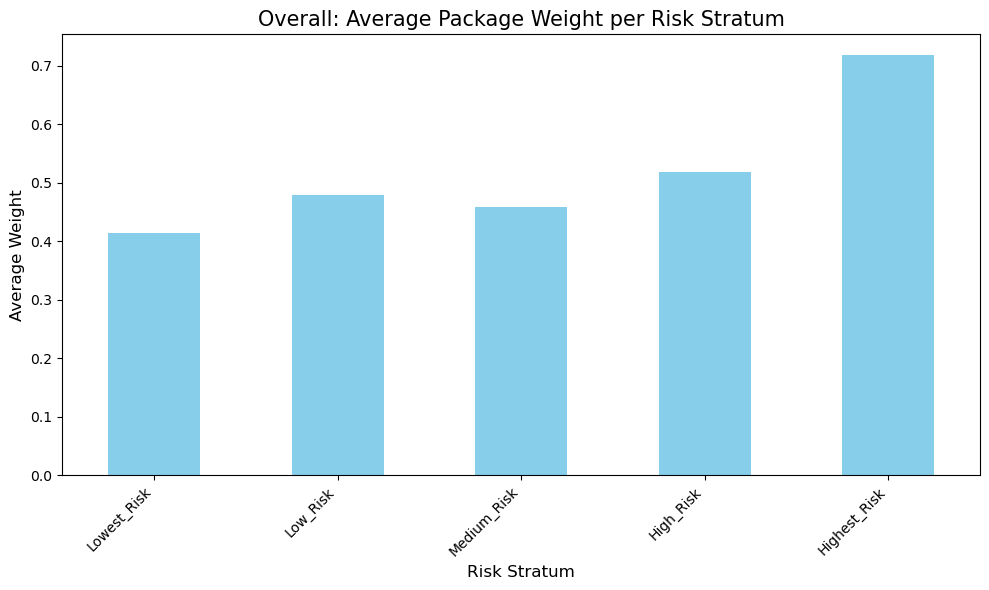

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


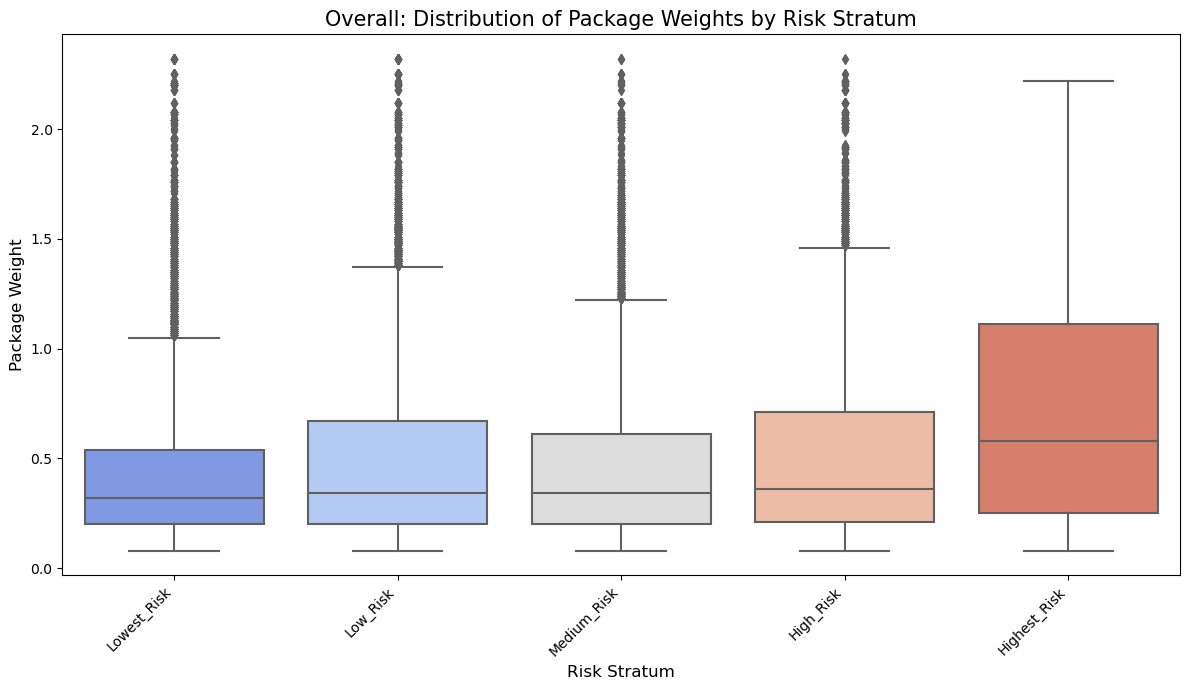

In [14]:
if 'stratified_df' in locals() and stratified_df is not None and \
   'Weight' in stratified_df.columns and stratum_col_name in stratified_df.columns:

    print("\n\n--- Overall Dataset: Average Package Weight per Risk Stratum ---")
    avg_weight_per_stratum = stratified_df.groupby(stratum_col_name)['Weight'].agg(
        Average_Weight='mean',
        Median_Weight='median',
        Package_Count='count'
    ).reindex(strata_config['labels'])
    print(avg_weight_per_stratum)

    if not avg_weight_per_stratum['Average_Weight'].isnull().all():
        plt.figure(figsize=(10, 6))
        avg_weight_per_stratum['Average_Weight'].plot(kind='bar', color='skyblue', yerr=avg_weight_per_stratum.get('Std_Dev_Weight')) # Optional error bars if you calculate std
        plt.title('Overall: Average Package Weight per Risk Stratum', fontsize=15)
        plt.xlabel('Risk Stratum', fontsize=12)
        plt.ylabel('Average Weight', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Box plot for more detail on distribution
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=stratified_df, x=stratum_col_name, y='Weight', order=strata_config['labels'], palette='coolwarm')
        plt.title('Overall: Distribution of Package Weights by Risk Stratum', fontsize=15)
        plt.xlabel('Risk Stratum', fontsize=12)
        plt.ylabel('Package Weight', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping Weight Analysis: 'Weight' or stratum column missing.")

### Specific Date

In [15]:
# Set your filters here
# Instructions:
# 1. Provide a value for ONLY ONE of the three filter variables.
# 2. Set the other two to None.
# 3. If all are None, the entire dataset will be analyzed.

filter_by_date = '2023-08-09'  # Format: 'YYYY-MM-DD' or None
filter_by_week = None          # Format: 'YYYY-MM-DD' (any date in the week) or None
filter_by_month = None         # Format: 'YYYY-MM' or None

In [16]:
# Applies the filter from Cell 1 and creates `analysis_df` for the next cell.

analysis_df = stratified_df.copy()
filter_title_part = "Overall"

if 'DateOfReport' in stratified_df.columns:
    stratified_df['DateOfReport'] = pd.to_datetime(stratified_df['DateOfReport'])

    if filter_by_date:
        date_obj = pd.to_datetime(filter_by_date)
        analysis_df = stratified_df[stratified_df['DateOfReport'].dt.date == date_obj.date()]
        filter_title_part = f"Date: {date_obj.strftime('%Y-%m-%d')}"

    elif filter_by_week:
        week_obj = pd.to_datetime(filter_by_week)
        year, week_num, _ = week_obj.isocalendar()
        analysis_df = stratified_df[
            (stratified_df['DateOfReport'].dt.isocalendar().year == year) &
            (stratified_df['DateOfReport'].dt.isocalendar().week == week_num)
        ]
        filter_title_part = f"Week: {year}-W{week_num}"

    elif filter_by_month:
        analysis_df = stratified_df[stratified_df['DateOfReport'].dt.strftime('%Y-%m') == filter_by_month]
        filter_title_part = f"Month: {filter_by_month}"
else:
    print("Warning: 'DateOfReport' column not found. Skipping date filter.")

--- Package Distribution by Stratum (Date: 2023-08-09) ---


,Package_Count,Percentage
Risk Stratum,,
Lowest_Risk,110,45.83%
Low_Risk,35,14.58%
Medium_Risk,51,21.25%
High_Risk,34,14.17%
Highest_Risk,10,4.17%


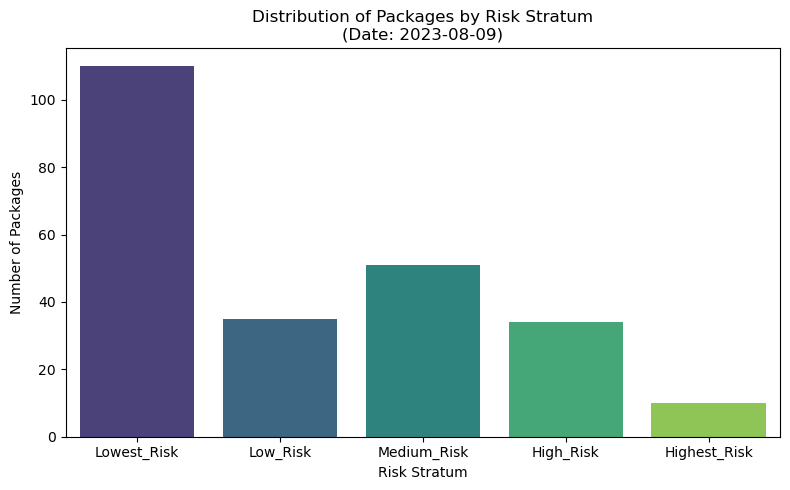

In [21]:
# Cell 7: Stratum Distribution Summary

# This cell uses 'analysis_df' to show the package distribution across strata,
# respecting the active filter from Cell 1.

if 'analysis_df' in locals() and not analysis_df.empty:

    # --- 1. Calculate the distribution ONCE ---
    # value_counts() is the most direct way to get counts for each category.
    # .reindex() ensures all strata are present in the correct order, even if count is 0.
    stratum_counts = analysis_df[stratum_col_name].value_counts().reindex(
        strata_config['labels'], fill_value=0
    )

    # --- 2. Display the results as a styled summary table ---
    # Create a DataFrame for a more professional-looking output.
    distribution_summary_df = pd.DataFrame({
        'Package_Count': stratum_counts,
        'Percentage': (stratum_counts / stratum_counts.sum()) * 100 if stratum_counts.sum() > 0 else 0
    })
    distribution_summary_df.index.name = 'Risk Stratum'

    print(f"--- Package Distribution by Stratum ({filter_title_part}) ---")
    display(distribution_summary_df.style.format({
        'Package_Count': '{:,.0f}',
        'Percentage': '{:.2f}%'
    }))

    # --- 3. Visualize the distribution with a bar plot ---
    # We use sns.barplot with the pre-calculated data.
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=distribution_summary_df.index,
        y=distribution_summary_df['Package_Count'],
        palette="viridis"
    )
    plt.title(f'Distribution of Packages by Risk Stratum\n({filter_title_part})')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Number of Packages')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    # This message shows if the filter resulted in an empty dataset.
    print(f"No package distribution data to display for the selected filter ({filter_title_part}).")

/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/3677362886.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = analysis_df.groupby(stratum_col_name).agg(


--- Summary for: Date: 2023-08-09 ---
                Total_Packages  Actual_Good_Rate  Avg_PredictedQualityProba
stratum_class0                                                             
Lowest_Risk                110          0.881818                   0.736112
Low_Risk                    35          0.771429                   0.512390
Medium_Risk                 51          0.705882                   0.392640
High_Risk                   34          0.705882                   0.301129
Highest_Risk                10          0.700000                   0.225503


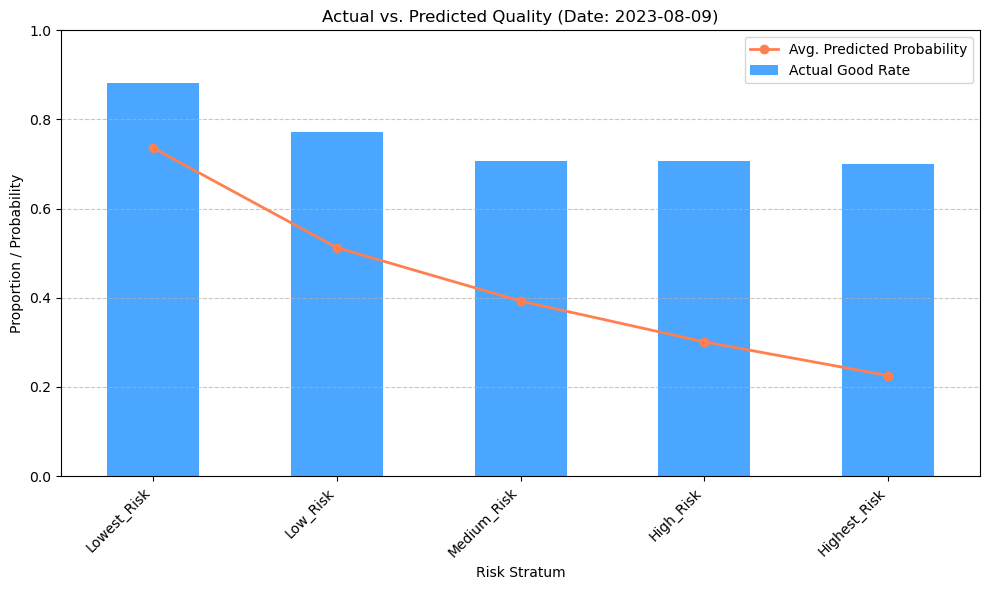

In [17]:
# Ensure data is valid before proceeding
if 'analysis_df' in locals() and not analysis_df.empty and \
   'ActualQuality' in analysis_df.columns and 'PredictedQualityProba' in analysis_df.columns:

    # Aggregate data in a single, efficient step
    summary_df = analysis_df.groupby(stratum_col_name).agg(
        Total_Packages=('ActualQuality', 'count'),
        Actual_Good_Rate=('ActualQuality', 'mean'),
        Avg_PredictedQualityProba=('PredictedQualityProba', 'mean')
    ).reindex(strata_config['labels'])

    # Display the final summary table
    print(f"--- Summary for: {filter_title_part} ---")
    print(summary_df)

    # Plot the results if there is data to show
    if not summary_df['Actual_Good_Rate'].isnull().all():
        plt.figure(figsize=(10, 6))
        summary_df['Actual_Good_Rate'].plot(kind='bar', color='dodgerblue', alpha=0.8, label='Actual Good Rate')
        summary_df['Avg_PredictedQualityProba'].plot(kind='line', marker='o', color='coral', linewidth=2, label='Avg. Predicted Probability')

        plt.title(f'Actual vs. Predicted Quality ({filter_title_part})')
        plt.ylabel('Proportion / Probability')
        plt.xlabel('Risk Stratum')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

elif 'analysis_df' in locals() and analysis_df.empty:
    print("\nSkipping analysis: The current filter resulted in an empty dataset.")
else:
    print("\nSkipping analysis: Required DataFrame or columns are missing.")

/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/1464966447.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  analysis_df.pivot_table(


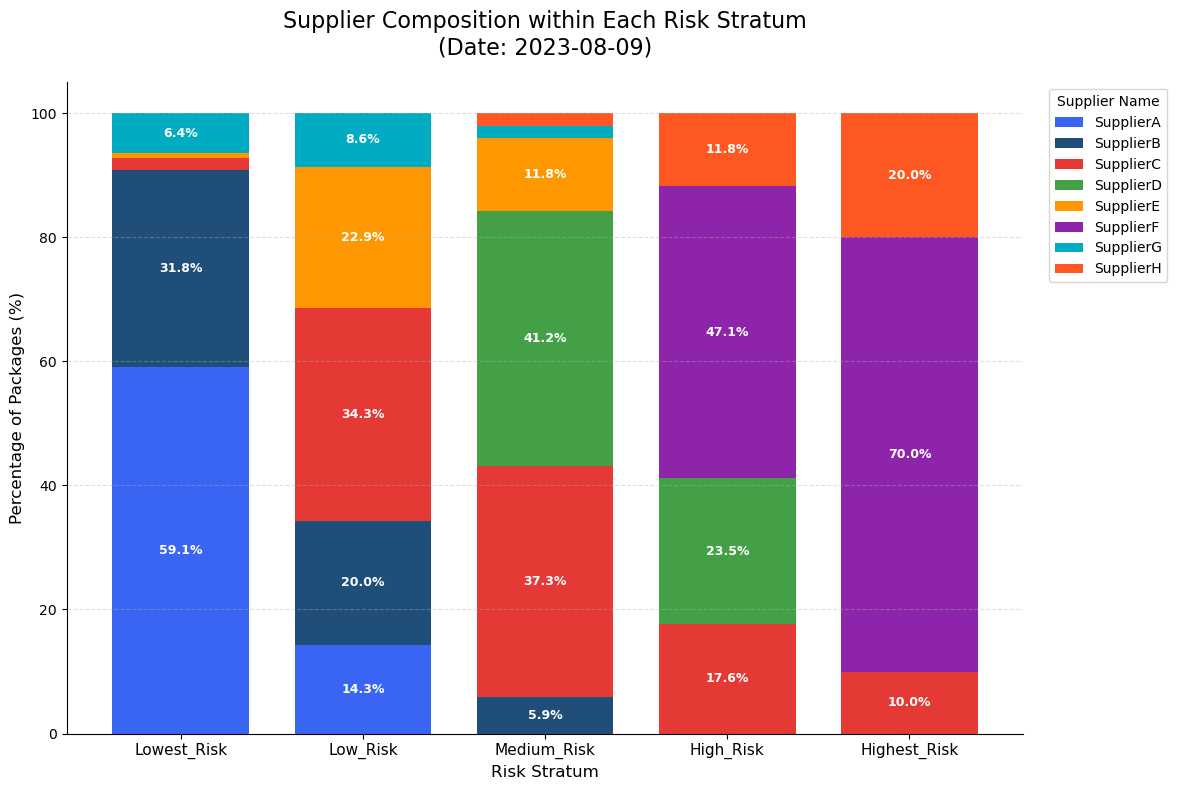

In [18]:
try:
    # Correctly pivot and count the data using 'aggfunc=size', which counts occurrences.
    # Then normalize to get percentages and ensure correct stratum order.
    supplier_dist_df = (
        analysis_df.pivot_table(
            index=stratum_col_name,
            columns='SupplierName',
            aggfunc='size',          # Correctly counts packages per group
            fill_value=0
        )
        .apply(lambda row: 100 * row / row.sum(), axis=1)
        .reindex(strata_config['labels'])
        .fillna(0)  # If a filter removes all data for a stratum, prevent NaN errors
    )
except (KeyError, ZeroDivisionError):
    # This handles cases where analysis_df is empty or missing required columns.
    supplier_dist_df = pd.DataFrame()


#  Visualization 
# We check if the resulting DataFrame has any actual data to plot.
if not supplier_dist_df.empty and supplier_dist_df.sum().sum() > 0:
    num_suppliers = supplier_dist_df.shape[1]
    
    # Define colors
    colors = ['#3a64f2', '#1f4e79', '#e53935', '#43a047', '#ff9800', 
              '#8e24aa', '#00acc1', '#ff5722', '#795548', '#607d8b',
              '#4caf50', '#2196f3', '#f44336', '#ffeb3b', '#9c27b0']
    if num_suppliers > len(colors):
        import matplotlib.cm as cm
        colors = cm.get_cmap('Set3', num_suppliers).colors

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    supplier_dist_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.75)

    # Customize titles and labels with the dynamic filter information
    ax.set_title(f'Supplier Composition within Each Risk Stratum\n({filter_title_part})', fontsize=16, pad=20)
    ax.set_xlabel('Risk Stratum', fontsize=12)
    ax.set_ylabel('Percentage of Packages (%)', fontsize=12)
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    
    ax.legend(title='Supplier Name', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Add percentage labels for segments > 5%
    for container in ax.containers:
        labels = [f'{h:.1f}%' if h > 5 else '' for h in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=9, color='white', fontweight='bold')
    
    # Final styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust for legend
    plt.show()

else:
    # This message now accurately reflects why there's no plot.
    print(f"No supplier data to plot for the selected filter ({filter_title_part}).")

In [19]:
top_n_suppliers = 5

try:
    # --- Data Preparation (Efficiently done once) ---
    # First, count packages for each Stratum-Supplier combination.
    supplier_counts = analysis_df.groupby([stratum_col_name, 'SupplierName']).size().to_frame('Package_Count')

    # Second, calculate the percentage contribution within each stratum.
    # groupby/transform is highly efficient for this.
    stratum_totals = supplier_counts.groupby(level=0)['Package_Count'].transform('sum')
    supplier_counts['Percentage_of_Stratum'] = (supplier_counts['Package_Count'] / stratum_totals) * 100
    
    # Sort for easy selection of top N later
    supplier_counts = supplier_counts.sort_values(
        by=[stratum_col_name, 'Package_Count'], ascending=[True, False]
    ).reset_index()

except (KeyError, ZeroDivisionError):
    supplier_counts = pd.DataFrame() # Ensure it's an empty DataFrame on error

if not supplier_counts.empty:
    print(f"--- Top {top_n_suppliers} Suppliers per Stratum ({filter_title_part}) ---")

    # Loop through each stratum just for printing the results.
    for stratum_label in strata_config['labels']:
        print(f"\n--- Stratum: {stratum_label} ---")
        
        # Select the pre-calculated data for the current stratum and get the top N
        top_suppliers_df = supplier_counts[supplier_counts[stratum_col_name] == stratum_label].head(top_n_suppliers)

        if not top_suppliers_df.empty:
            # Format the percentage for cleaner display
            top_suppliers_df['Percentage_of_Stratum'] = top_suppliers_df['Percentage_of_Stratum'].map('{:.2f}%'.format)
            
            # Print the final formatted table without the index
            print(top_suppliers_df[['SupplierName', 'Package_Count', 'Percentage_of_Stratum']].to_string(index=False))
        else:
            print("    No suppliers found in this stratum for the current filter.")
else:
    print(f"No supplier data to analyze for the selected filter ({filter_title_part}).")

--- Top 5 Suppliers per Stratum (Date: 2023-08-09) ---

--- Stratum: Lowest_Risk ---
SupplierName  Package_Count Percentage_of_Stratum
   SupplierA             65                59.09%
   SupplierB             35                31.82%
   SupplierG              7                 6.36%
   SupplierC              2                 1.82%
   SupplierE              1                 0.91%

--- Stratum: Low_Risk ---
SupplierName  Package_Count Percentage_of_Stratum
   SupplierC             12                34.29%
   SupplierE              8                22.86%
   SupplierB              7                20.00%
   SupplierA              5                14.29%
   SupplierG              3                 8.57%

--- Stratum: Medium_Risk ---
SupplierName  Package_Count Percentage_of_Stratum
   SupplierD             21                41.18%
   SupplierC             19                37.25%
   SupplierE              6                11.76%
   SupplierB              3                 5.88%
   Suppl

/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/4178606044.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  supplier_counts = analysis_df.groupby([stratum_col_name, 'SupplierName']).size().to_frame('Package_Count')
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/4178606044.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stratum_totals = supplier_counts.groupby(level=0)['Package_Count'].transform('sum')


In [20]:
# Cell 6: Supplier Risk Profile Summary Table

try:
    # --- 1. Calculate Base Statistics (Total Packages & Overall Good Rate) ---
    summary_df = analysis_df.groupby('SupplierName').agg(
        TotalPackages=('ActualQuality', 'size'),
        Overall_Good_Rate=('ActualQuality', 'mean')
    )

    # --- 2. Calculate Distribution of Supplier's Packages into Strata (%) ---
    stratum_dist_pct = (
        analysis_df.pivot_table(
            index='SupplierName',
            columns=stratum_col_name,
            aggfunc='size',
            fill_value=0
        )
        .apply(lambda row: 100 * row / row.sum(), axis=1)
        .rename(columns=lambda c: f'% in {c}')
    )

    # --- 3. Calculate Actual Good Rate within Highest and Lowest Risk Strata ---
    highest_risk_label = strata_config['labels'][0]
    lowest_risk_label = strata_config['labels'][-1]
    specific_rates = (
        analysis_df.pivot_table(
            index='SupplierName',
            columns=stratum_col_name,
            values='ActualQuality',
            aggfunc='mean'
        )[[highest_risk_label, lowest_risk_label]]
        .rename(columns=lambda c: f'Good_Rate_in_{c}')
    )

    # --- 4. Assemble the Final Table ---
    final_summary_df = summary_df.join([stratum_dist_pct, specific_rates], how='left')

    sort_col = f'% in {highest_risk_label}'
    if sort_col in final_summary_df.columns:
        final_summary_df = final_summary_df.sort_values(by=sort_col, ascending=False)

except (KeyError, ZeroDivisionError):
    final_summary_df = pd.DataFrame()


# --- 5. Display the Styled Table (without colors) ---
if not final_summary_df.empty:
    print(f"--- Supplier Risk Profile ({filter_title_part}) ---")

    percent_cols = [col for col in final_summary_df.columns if '%' in col or 'Rate' in col]

    # Use the Styler for clean formatting of numbers and percentages, but without any colors.
    styled_df = final_summary_df.style.format('{:.2f}%', subset=percent_cols, na_rep='-') \
                                      .format({'TotalPackages': '{:,.0f}'})

    display(styled_df)
else:
    print(f"No supplier profile data to display for the selected filter ({filter_title_part}).")

--- Supplier Risk Profile (Date: 2023-08-09) ---


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/2988848335.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = analysis_df.groupby('SupplierName').agg(
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/2988848335.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  analysis_df.pivot_table(
/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_2451/2988848335.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  analysis_df.pivot_

,TotalPackages,Overall_Good_Rate,% in Lowest_Risk,% in Low_Risk,% in Medium_Risk,% in High_Risk,% in Highest_Risk,Good_Rate_in_Lowest_Risk,Good_Rate_in_Highest_Risk
SupplierName,,,,,,,,,
SupplierA,70,0.885714,92.857143,7.142857,0.000000,0.000000,0.000000,0.876923,nan
SupplierB,45,0.866667,77.777778,15.555556,6.666667,0.000000,0.000000,0.885714,nan
SupplierG,11,0.727273,63.636364,27.272727,9.090909,0.000000,0.000000,0.857143,nan
SupplierE,15,0.866667,6.666667,53.333333,40.000000,0.000000,0.000000,1.000000,nan
SupplierC,40,0.700000,5.000000,30.000000,47.500000,15.000000,2.500000,1.000000,1.000000
SupplierD,29,0.724138,0.000000,0.000000,72.413793,27.586207,0.000000,nan,nan
SupplierF,23,0.652174,0.000000,0.000000,0.000000,69.565217,30.434783,nan,0.571429
SupplierH,7,0.714286,0.000000,0.000000,14.285714,57.142857,28.571429,nan,1.000000
